# Cryptoviz- Final training notebook

## Recurrent neural based Cryptocurrency price prediction

### Cryptocurrencies: bitcoin(BTC), ethereum(ETH), ripple(XRP), bitcoin cash(BCH)  


### Requirements:
- Tensorflow 1.x
- keras
- binance client api for data extraction
- pandas
- numpy
- matplotlib
- sklearn


### Installation of binance

In [2]:
!pip install python-binance

     |████████████████████████████████| 3.1MB 20.2MB/s 
     |████████████████████████████████| 1.1MB 50.8MB/s 
     |████████████████████████████████| 358kB 53.2MB/s 
     |████████████████████████████████| 61kB 12.0MB/s 
     |████████████████████████████████| 2.3MB 48.9MB/s 
     |████████████████████████████████| 235kB 57.1MB/s 
     |████████████████████████████████| 61kB 11.7MB/s 


### Setting tensorflow version to 1.x if default version is tensorflow 2.0(colab)

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


### Source code:

In [2]:
import datetime
from binance.client import Client
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import sys

Using TensorFlow backend.


In [0]:
# Instanciate Binance client
client = Client('API_KEY', 'SECRET_KEY')

In [0]:
symbol = 'ETHUSDT'
CRYPTOCURRENCY = client.get_historical_klines(symbol=symbol, interval=Client.KLINE_INTERVAL_30MINUTE, start_str="31 july 2015")
CRYPTOCURRENCY = pd.DataFrame(CRYPTOCURRENCY, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])

CRYPTOCURRENCY['Open time'] = pd.to_datetime(CRYPTOCURRENCY['Open time'], unit='ms')

CRYPTOCURRENCY.set_index('Open time', inplace=True)

CRYPTOCURRENCY['Close']=CRYPTOCURRENCY['Close'].astype(float)

data = CRYPTOCURRENCY.iloc[:,3:4].astype(float).values


In [4]:
CRYPTOCURRENCY.shape

(45831, 11)

In [0]:
# Scale data
scaler= MinMaxScaler()
data = scaler.fit_transform(data)

### Splitting into training and test data

The complete data is split in 75% for training an 25% for testing.

The training sequence is created such that target(Y) is 1 time unit ahead of X, i.e

If X is x<sub>0</sub>, x<sub>1</sub>, x<sub>2</sub>, x<sub>3</sub>, x<sub>4</sub>,..., x<sub>n-1</sub> 

   Y is x<sub>1</sub>, x<sub>2</sub>, x<sub>3</sub>, x<sub>4</sub>, x<sub>5</sub>,..., x<sub>n</sub>
   
X is reshaped to a 3x3 matrix of order ((number of rows) x (1 i.e each number in the sequence) x (no. of features which is 1, we use 'close' values only))

In [0]:
#automatically take 75% data for training
len_seq = round(0.75 * len(data))

training_set = data[:len_seq]
test_set = data[len_seq:]
# Data preprocessing (Dividing datasets to training and testing data)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]

X_test = test_set[0:len(test_set)-1]
y_test = test_set[1:len(test_set)]

X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

In [10]:
X_train.shape

(34371, 1, 1)

### RNN architecture definiton
#### A sequential model 

##### Resources:
LSTM:

https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

https://colah.github.io/posts/2015-08-Understanding-LSTMs/

https://medium.com/mlreview/understanding-lstm-and-its-diagrams-37e2f46f1714

https://stackabuse.com/solving-sequence-problems-with-lstm-in-keras/

https://machinelearningmastery.com/5-step-life-cycle-long-short-term-memory-models-keras/

Deep learning:

https://towardsdatascience.com/everything-you-need-to-know-about-neural-networks-and-backpropagation-machine-learning-made-easy-e5285bc2be3a

Loss Function: mean squared error

https://towardsdatascience.com/common-loss-functions-in-machine-learning-46af0ffc4d23

https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/


Optimizer : ADAM

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

https://ruder.io/optimizing-gradient-descent/index.html#adam

https://arxiv.org/pdf/1412.6980.pdf

In [7]:
model= Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(1, 1)))
model.add(LSTM(256))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

###  Training  the model

##### We use 20% of the training data for validation during training. Loss and MSE should reduce throught the training for the model to converge. We do not shuffle the data to prevent the breaking of the sequence.


In [8]:

history = model.fit(X_train, y_train, epochs=50, batch_size=16, shuffle=False ,validation_split=0.2)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 27498 samples, validate on 6875 samples
Epoch 1/50





27498/27498 [==============================] - 17s 634us/step - loss: 4.8632e-04 - mean_squared_error: 4.8632e-04 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 2/50
27498/27498 [==============================] - 15s 560us/step - loss: 5.5666e-04 - mean_squared_error: 5.5666e-04 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 3/50
27498/27498 [==============================] - 16s 564us/step - loss: 9.2310e-04 - mean_squared_error: 9.2310e-04 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 4/50
27498/27498 [==============================] - 15s 557us/step - loss: 9.8869e-04 - mean_squared_error: 9.8869e-04 - val_loss: 0.0040 - val_mean_squared_error: 0.0040
Epoch 5/50
27498/27498 [==============================] - 15s 561us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.0039 - val

The history object is the output of the fit operation.The History.history attribute is a dictionary recording training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values

In [9]:
history.history.keys()
#print(history.history)

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])

### Saving the model

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("eth_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("eth_model.h5")
print("Saved model to disk")

### Loading the model

In [ ]:
# load json and create model
json_file = open('eth_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("eth_model.h5")
print("Loaded model from disk")

### Training Graphs for loss and mean squared error

#### More close the training and validation curves are to each other, more accurate is the model 

### Training loss vs Validation loss

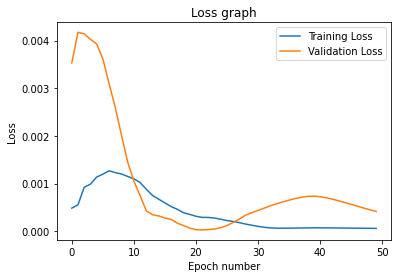

In [19]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss graph')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend(loc="upper right")
plt.savefig("adam_loss_ethereum.png")
plt.show()


### Training MSE vs Validation MSE

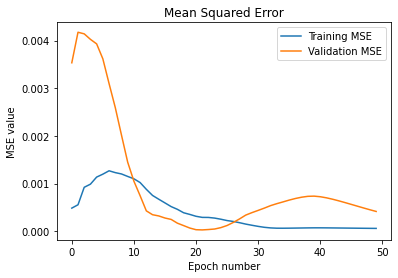

In [20]:
plt.plot(history.history['mean_squared_error'], label='Training MSE')
plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
plt.title('Mean Squared Error')
plt.ylabel('MSE value')
plt.xlabel('Epoch number')
plt.legend(loc="upper right")
plt.savefig("adam_mse_ethereum.png")
plt.show()


## Prediction of prices

In [0]:
# we use test dataset here
predicted_price = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price)
real_price = scaler.inverse_transform(y_test)

### Prediction Graph

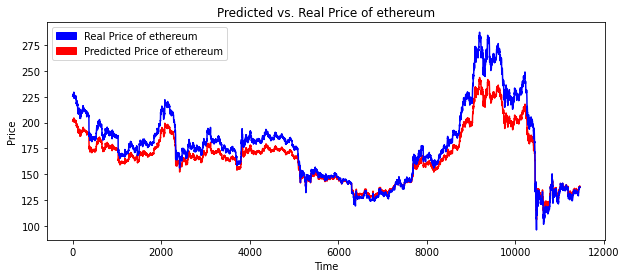

In [21]:
#change the crypto name
plt.figure(figsize=(10,4))
red_patch = mpatches.Patch(color='red', label='Predicted Price of ethereum')
blue_patch = mpatches.Patch(color='blue', label='Real Price of ethereum')
plt.legend(handles=[blue_patch, red_patch])
plt.plot(predicted_price, color='red', label='Predicted Price of ethereum')
plt.plot(real_price, color='blue', label='Real Price of ethereum')
plt.title('Predicted vs. Real Price of ethereum')
plt.xlabel('Time')
plt.ylabel('Price')
plt.savefig("ethereum_prediction_adam.png")
plt.show()
